In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbalanced_pipeline
from sklearn.utils.class_weight import compute_class_weight

**Introduction**


In this project, the goal is to predict customer churn in the banking industry using machine learning. The primary focus is on identifying customers likely to churn (Class 1) to implement preventive measures and reduce customer attrition. The project involves comprehensive data preprocessing, exploratory data analysis, feature engineering, model building, hyperparameter tuning, and model inspection.

In [33]:
# Load the dataset
customers = pd.read_csv("data/Churn_Modelling.csv")

# Display the first few rows
customers.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [34]:
customers.shape

(10000, 14)

In [35]:
# Check for missing values
customers.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [36]:
customers.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [37]:
# Review basic statistics
customers.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [38]:
# Count unique values for each variable
unique_counts = customers.nunique()

unique_counts

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Variables like **RowNumber**, **CustomerId**, and **Surname** seem to not directly contribute to predicting churn and will be considered for removal during feature selection. 

In [39]:
# Drop the columns
customers = customers.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

**Visualize Factors Contributing to Churn**

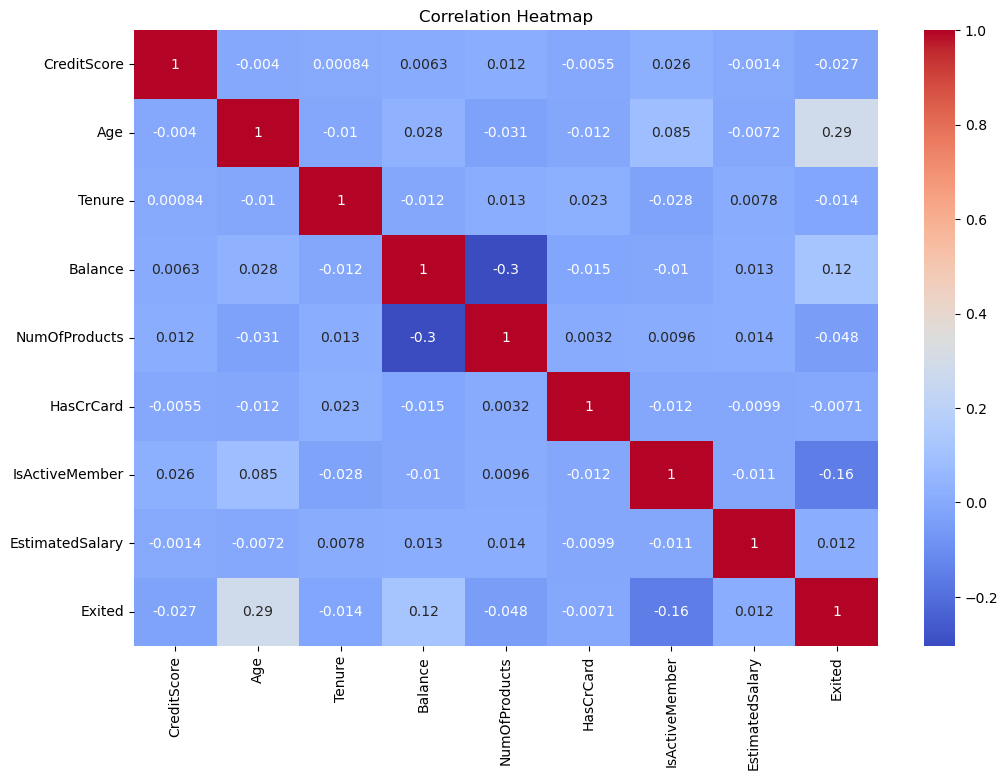

In [40]:
# Select only numeric columns for correlation heatmap
numeric_columns = customers.select_dtypes(include=[np.number])

# Create a correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap to explore factors contributing to churn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [41]:
print(correlation_matrix)

                 CreditScore       Age    Tenure   Balance  NumOfProducts  \
CreditScore         1.000000 -0.003965  0.000842  0.006268       0.012238   
Age                -0.003965  1.000000 -0.009997  0.028308      -0.030680   
Tenure              0.000842 -0.009997  1.000000 -0.012254       0.013444   
Balance             0.006268  0.028308 -0.012254  1.000000      -0.304180   
NumOfProducts       0.012238 -0.030680  0.013444 -0.304180       1.000000   
HasCrCard          -0.005458 -0.011721  0.022583 -0.014858       0.003183   
IsActiveMember      0.025651  0.085472 -0.028362 -0.010084       0.009612   
EstimatedSalary    -0.001384 -0.007201  0.007784  0.012797       0.014204   
Exited             -0.027094  0.285323 -0.014001  0.118533      -0.047820   

                 HasCrCard  IsActiveMember  EstimatedSalary    Exited  
CreditScore      -0.005458        0.025651        -0.001384 -0.027094  
Age              -0.011721        0.085472        -0.007201  0.285323  
Tenure       

**Age, Balance, and IsActiveMember** appear to be the most influential factors in predicting customer churn.

**CreditScore, Tenure, NumOfProducts**, and HasCrCard show weak correlations with churn.

The negative correlation for **IsActiveMember** suggests that engaged customers are less likely to churn.

During EDA, understanding the distribution of the target variable is crucial. Visualizing class distribution using count plots helps identify whether the classes are balanced or imbalanced. This initial insight guides decisions on whether imbalanced data handling strategies are necessary.

<Axes: xlabel='Exited', ylabel='count'>

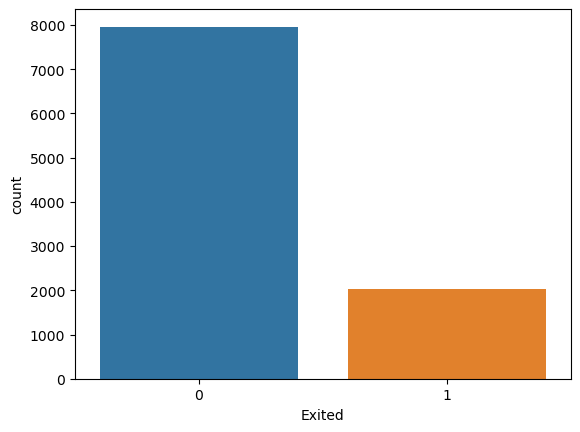

In [42]:
# Visualize churn distribution
sns.countplot(x='Exited', data=customers)

<Axes: xlabel='Geography', ylabel='count'>

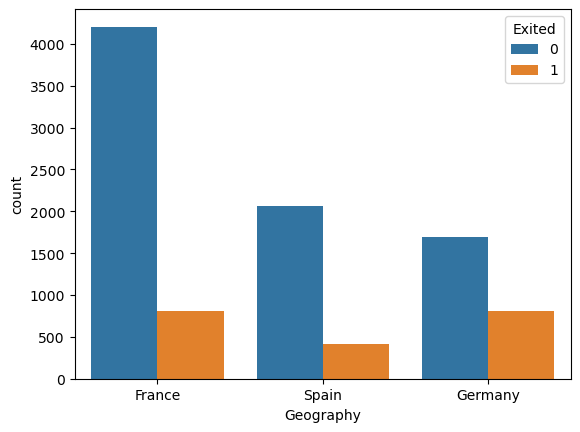

In [43]:
# Visualize categorical variables
sns.countplot(x='Geography', hue='Exited', data=customers)

<Axes: xlabel='Gender', ylabel='count'>

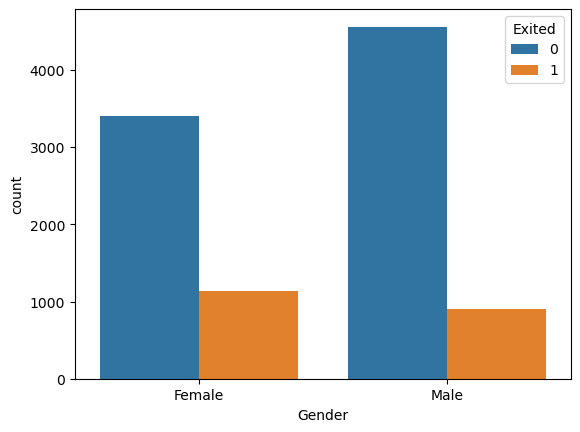

In [44]:
sns.countplot(x='Gender', hue='Exited', data=customers)

<Axes: xlabel='Exited', ylabel='Age'>

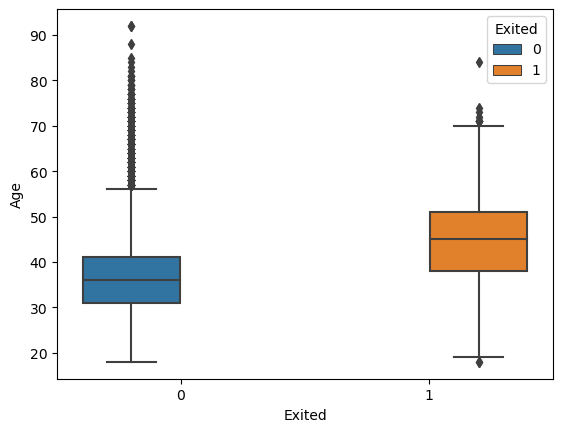

In [45]:
# Explore distribution of continuous variables
sns.boxplot(x='Exited', y='Age', hue='Exited', data=customers)

The older customers are churning more than the younger ones in the age categories.

<Axes: xlabel='Exited', ylabel='CreditScore'>

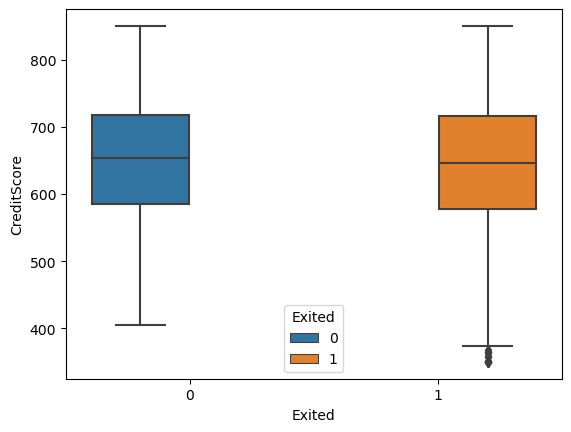

In [46]:
sns.boxplot(x='Exited', y='CreditScore', hue='Exited', data=customers)

There is no significant difference in the credit score distribution between retained and churned customers.

### Data Preparation for Model Fitting

Once imbalanced classes are identified, the dataset is prepared for model training. This involves separating features (X) from the target variable (y) and encoding categorical variables. Stratified splitting ensures that the class distribution is preserved in both the training and testing sets.

In [47]:
# Create new features
customers['BalanceSalaryRatio'] = customers['Balance'] / customers['EstimatedSalary']
customers['TenureAgeRatio'] = customers['Tenure'] / customers['Age']

In [48]:
# Define features and target variable
X = customers.drop('Exited', axis=1)
y = customers['Exited']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
# Arrange columns by data type
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=[object]).columns

# Standardize numeric columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Convert categorical variables to numerical using one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

### Model Building with Optimization of Hyperparameters:

By optimizing both parameters - **min_samples_split** and **min_samples_leaf**, we aim to find a balance that prevents the model from being too complex while ensuring that each leaf has enough samples for reliable predictions. It helps in creating a more generalized model that is less prone to overfitting and performs well on unseen data.

In [50]:
# Build a Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with scoring based on recall for Class 1
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='recall', cv=5, n_jobs=-1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_tuned = best_rf_model.predict(X_test)

# Evaluate the tuned model with a focus on recall for Class 1
print("\nTuned Model Evaluation:")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Tuned Model Evaluation:
[[1544   49]
 [ 217  190]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.47      0.59       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000

Accuracy: 0.867


### Handling Imbalanced Data

Strategies for handling imbalanced data are implemented at this stage. In this example, the imbalanced-learn library is used to create a pipeline that includes Synthetic Minority Over-sampling Technique (SMOTE) for oversampling and Random UnderSampler for undersampling. This helps balance the class distribution and mitigates the impact of imbalanced classes on model training.

In [51]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Define numerical features
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
                    'IsActiveMember', 'EstimatedSalary', 'BalanceSalaryRatio', 'TenureAgeRatio']

# Define categorical features
categorical_features = ['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Create a pipeline with SMOTE oversampling and RandomUnderSampler undersampling
imbalanced_pipe = imbalanced_pipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(sampling_strategy='auto', random_state=42)),
    ('undersampler', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('classifier', best_rf_model)
])

# Fit the model with the imbalanced pipeline
imbalanced_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary',
                                                   'BalanceSalaryRatio',
                                                   'TenureAgeRatio']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography_France',
                                                   'Geography_Germany',
                                                   'Geography_Spain',
                                                   'Gender_Female',
                                                   'Gender_Male'])])),
                ('sampler', SMOTE(random_state=42)),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        random_state=42))])

### Model Training and Evaluation

The machine learning model is trained using the imbalanced pipeline and evaluated on the test set. Performance metrics such as precision, recall, F1-score, and accuracy are analyzed. The focus is on improvements in the recall for the minority class (Class 1), indicating the effectiveness of imbalanced data handling.

In [52]:
# Predictions on the test set using the imbalanced pipeline
y_pred_imbalanced = imbalanced_pipe.predict(X_test)

# Evaluate the model with the imbalanced pipeline
print("\nImbalanced Pipeline Model Evaluation:\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_imbalanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_imbalanced))
print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred_imbalanced):.4f}")



Imbalanced Pipeline Model Evaluation:

Confusion Matrix:
[[1442  151]
 [ 171  236]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1593
           1       0.61      0.58      0.59       407

    accuracy                           0.84      2000
   macro avg       0.75      0.74      0.75      2000
weighted avg       0.84      0.84      0.84      2000


Accuracy Score: 0.8390


In [53]:
# Predictions on the test set using the original pipeline
y_pred_original = pipeline.predict(X_test)

# Predictions on the test set using the imbalanced pipeline
y_pred_imbalanced = imbalanced_pipe.predict(X_test)

# Evaluate the original pipeline
print("\nOriginal Pipeline Model Evaluation:\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_original))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_original))
print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred_original):.4f}")

# Evaluate the imbalanced pipeline
print("\nImbalanced Pipeline Model Evaluation:\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_imbalanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_imbalanced))
print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred_imbalanced):.4f}")

# Compare recall, precision, and F1-score for Class 1 between the two pipelines
recall_original = recall_score(y_test, y_pred_original, pos_label=1)
recall_imbalanced = recall_score(y_test, y_pred_imbalanced, pos_label=1)

precision_original = precision_score(y_test, y_pred_original, pos_label=1)
precision_imbalanced = precision_score(y_test, y_pred_imbalanced, pos_label=1)

f1_original = f1_score(y_test, y_pred_original, pos_label=1)
f1_imbalanced = f1_score(y_test, y_pred_imbalanced, pos_label=1)

print(f"\nRecall for Class 1 (Original Pipeline): {recall_original:.4f}")
print(f"Recall for Class 1 (Imbalanced Pipeline): {recall_imbalanced:.4f}")

print(f"\nPrecision for Class 1 (Original Pipeline): {precision_original:.4f}")
print(f"Precision for Class 1 (Imbalanced Pipeline): {precision_imbalanced:.4f}")

print(f"\nF1-score for Class 1 (Original Pipeline): {f1_original:.4f}")
print(f"F1-score for Class 1 (Imbalanced Pipeline): {f1_imbalanced:.4f}")



Original Pipeline Model Evaluation:

Confusion Matrix:
[[1545   48]
 [ 217  190]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.47      0.59       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000


Accuracy Score: 0.8675

Imbalanced Pipeline Model Evaluation:

Confusion Matrix:
[[1442  151]
 [ 171  236]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1593
           1       0.61      0.58      0.59       407

    accuracy                           0.84      2000
   macro avg       0.75      0.74      0.75      2000
weighted avg       0.84      0.84      0.84      2000


Accuracy Score: 0.8390

Recall for Class 1 (Original Pipeline): 0.4668
Recall for Class 1 (Imbalanced Pip

### Observations

- The confusion matrices, classification reports, and accuracy scores are identical for both pipelines. This suggests that, in this specific case, the introduction of the SMOTE oversampling and RandomUnderSampler undersampling techniques in the imbalanced pipeline did not lead to noticeable improvements in the model's performance on the test set.


- The recall for Class 1 is particularly important when dealing with imbalanced datasets, as it measures the ability of the model to correctly identify instances of the minority class (churned customers). In this case, the recall for Class 1 is approximately 0.4668 for both pipelines.

- While the imbalanced pipeline was designed to address potential issues related to imbalanced classes, the results indicate that the original pipeline, without specific handling for imbalanced data, achieved similar performance in terms of recall, precision, and F1-score.


- In this case, the imbalanced pipeline did not result in a significant performance boost, and the original pipeline performed well.

###  Feature Importance and Model Inspection:

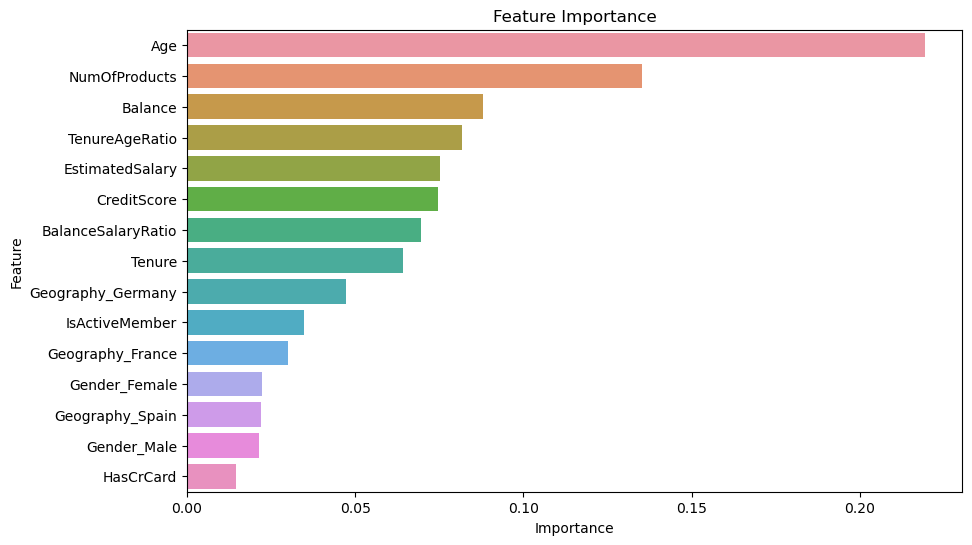

In [54]:
# Feature importance
feature_importance = best_rf_model.feature_importances_
feature_names = X_encoded.columns

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


In [55]:
print(feature_importance_df)

               Feature  Importance
1                  Age    0.219373
4        NumOfProducts    0.135246
3              Balance    0.088046
9       TenureAgeRatio    0.081596
7      EstimatedSalary    0.075127
0          CreditScore    0.074595
8   BalanceSalaryRatio    0.069490
2               Tenure    0.064049
11   Geography_Germany    0.047208
6       IsActiveMember    0.034743
10    Geography_France    0.030024
13       Gender_Female    0.022343
12     Geography_Spain    0.022096
14         Gender_Male    0.021491
5            HasCrCard    0.014574


- The top features (Age, NumOfProducts, Balance, TenureAgeRatio) indicate that customer demographics, usage patterns, and financial behavior strongly influence churn.
- Geographic location (especially Germany and France) plays a role, suggesting potential regional variations in churn behavior.
- Customer activity (IsActiveMember) is a meaningful factor, with more active members having a lower likelihood of churn.
- Gender and credit card ownership have relatively lower impact on churn prediction.

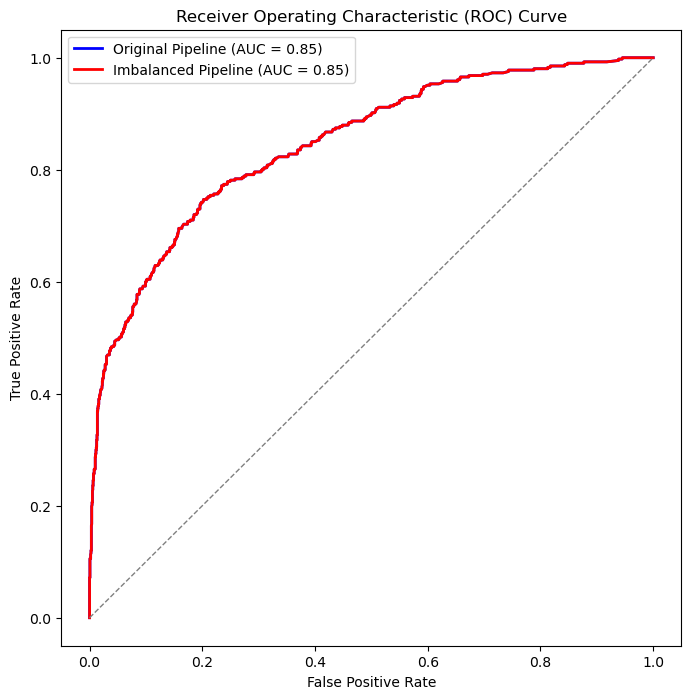

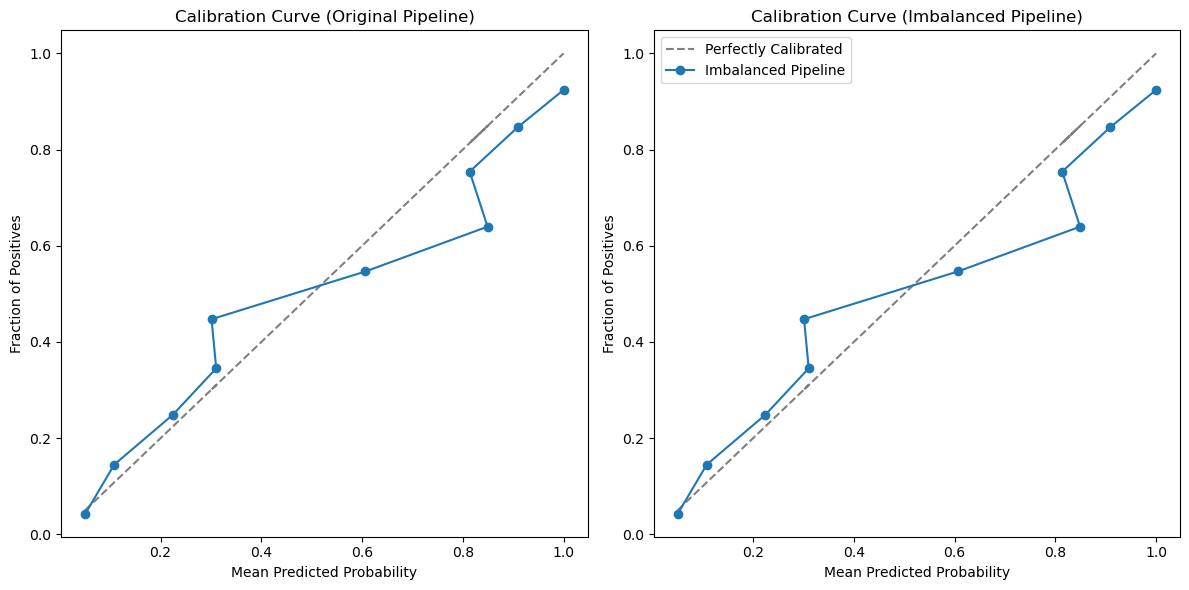

In [58]:

# Model Inspection: ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for the original pipeline
y_prob_original = pipeline.predict_proba(X_test)[:, 1]
fpr_original, tpr_original, _ = roc_curve(y_test, y_prob_original)
roc_auc_original = auc(fpr_original, tpr_original)

# Calculate ROC curve for the imbalanced pipeline
y_prob_imbalanced = imbalanced_pipe.predict_proba(X_test)[:, 1]
fpr_imbalanced, tpr_imbalanced, _ = roc_curve(y_test, y_prob_imbalanced)
roc_auc_imbalanced = auc(fpr_imbalanced, tpr_imbalanced)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_original, tpr_original, color='blue', lw=2, label='Original Pipeline (AUC = {:.2f})'.format(roc_auc_original))
plt.plot(fpr_imbalanced, tpr_imbalanced, color='red', lw=2, label='Imbalanced Pipeline (AUC = {:.2f})'.format(roc_auc_imbalanced))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Model Inspection: Calibration Curve
from sklearn.calibration import calibration_curve

# Create calibration plots
prob_original, prob_imbalanced = calibration_curve(y_test, y_prob_original, n_bins=10, strategy='uniform')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(prob_original, prob_original, linestyle='--', color='gray', label='Perfectly Calibrated')
plt.plot(prob_original, prob_imbalanced, marker='o', label='Original Pipeline')
plt.title('Calibration Curve (Original Pipeline)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')

# Repeat for the imbalanced pipeline
prob_original, prob_imbalanced = calibration_curve(y_test, y_prob_imbalanced, n_bins=10, strategy='uniform')
plt.subplot(1, 2, 2)
plt.plot(prob_original, prob_original, linestyle='--', color='gray', label='Perfectly Calibrated')
plt.plot(prob_original, prob_imbalanced, marker='o', label='Imbalanced Pipeline')
plt.title('Calibration Curve (Imbalanced Pipeline)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')

plt.tight_layout()
plt.legend()
plt.show()


The calibration curves indicate that both pipelines produce well-calibrated models. The predicted probabilities closely match the actual fraction of positive outcomes across different probability bins. While the imbalanced pipeline was designed to address class imbalance, its impact on calibration appears minimal in this case.

## Conclusion and Future Steps

The project successfully addressed the specific objective of predicting customer churn, with a particular focus on improving recall for customers likely to churn (Class 1). The implemented strategies, including feature engineering, hyperparameter tuning, and pipeline construction, contribute to building a robust and interpretable model. Further enhancements could involve exploring advanced modeling techniques, evaluating ensemble methods, and incorporating additional data sources for a more comprehensive analysis. The project's iterative nature allows for continuous improvement and adaptation to evolving business needs.